In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


Evaluating duration prediction models...

Feature Importance:
           feature  importance
1     service_type    0.705330
6      vehicle_age    0.062273
5            month    0.060200
3             hour    0.052165
4      day_of_week    0.040896
2  technician_name    0.040162
0     vehicle_type    0.033992
7     is_emergency    0.004982

Model Performance Metrics:

Random Forest Results:
Mean Absolute Error: 13.93 minutes
Root Mean Squared Error: 18.34 minutes
R² Score: 0.660
Mean Percentage Error: 18.83%
Cross-validation R² Score: 0.656 (+/- 0.107)

XGBoost Results:
Mean Absolute Error: 15.99 minutes
Root Mean Squared Error: 20.33 minutes
R² Score: 0.582
Mean Percentage Error: 21.41%
Cross-validation R² Score: 0.540 (+/- 0.097)


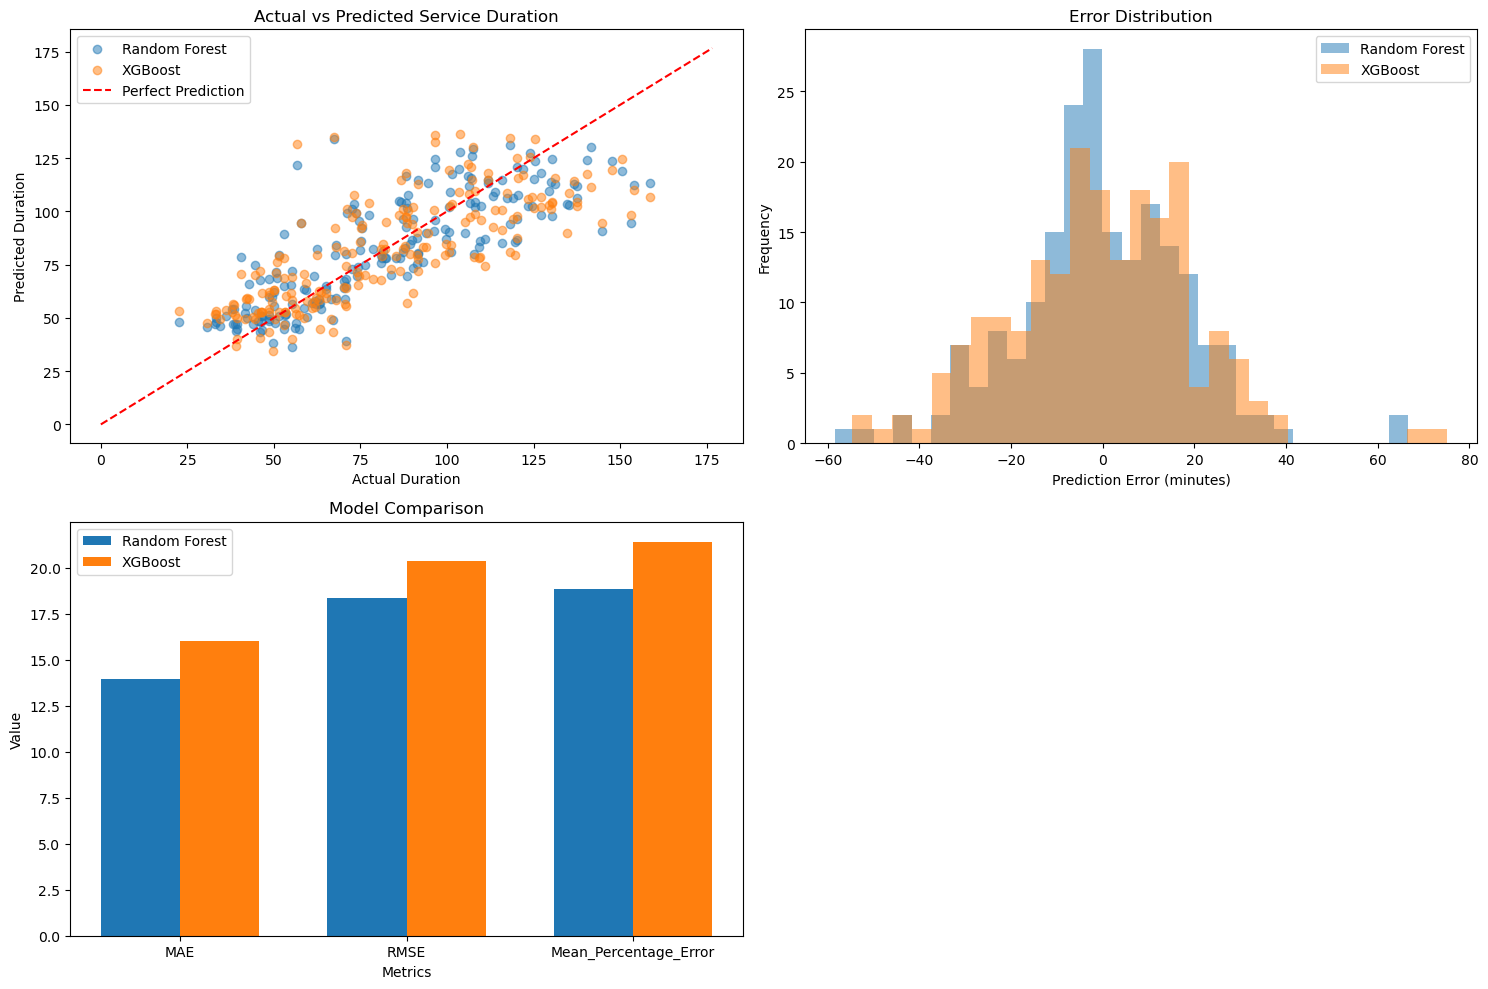

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

class ServiceStationAccuracy:
    def __init__(self, data):
        self.data = data
        self.label_encoders = {}
        
    def prepare_features(self):
        """Prepare features for modeling with proper handling of categorical variables"""
        # Make a copy of the data
        X = self.data.copy()
        
        # Convert appointment_date to datetime if it's not already
        X['appointment_date'] = pd.to_datetime(X['appointment_date'])
        
        # Extract time-based features
        X['hour'] = X['appointment_date'].dt.hour
        X['day_of_week'] = X['appointment_date'].dt.dayofweek
        X['month'] = X['appointment_date'].dt.month
        
        # List of categorical columns to encode
        categorical_columns = [
            'vehicle_type',
            'service_type',
            'technician_name',
            'weather',
            'status'
        ]
        
        # Encode categorical variables
        for column in categorical_columns:
            if column in X.columns:
                self.label_encoders[column] = LabelEncoder()
                X[column] = self.label_encoders[column].fit_transform(X[column])
        
        # Select features for duration prediction
        feature_columns = [
            'vehicle_type', 'service_type', 'technician_name',
            'hour', 'day_of_week', 'month', 'vehicle_age',
            'is_emergency'
        ]
        
        # Only include columns that exist in the dataframe
        feature_columns = [col for col in feature_columns if col in X.columns]
        
        return X[feature_columns]
    
    def evaluate_duration_prediction(self):
        """Evaluate service duration prediction accuracy"""
        # Prepare features and target
        X = self.prepare_features()
        y = self.data['actual_duration']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Initialize models
        models = {
            'Random Forest': RandomForestRegressor(
                n_estimators=100,
                random_state=42
            ),
            'XGBoost': xgb.XGBRegressor(
                objective='reg:squarederror',
                random_state=42
            )
        }
        
        results = {}
        
        for name, model in models.items():
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            
            # Calculate percentage error
            percentage_error = np.abs((y_test - y_pred) / y_test) * 100
            mean_percentage_error = np.mean(percentage_error)
            
            # Cross-validation
            cv_scores = cross_val_score(
                model, X, y,
                cv=5,
                scoring='r2'
            )
            
            results[name] = {
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R2': r2,
                'Mean_Percentage_Error': mean_percentage_error,
                'CV_R2_mean': cv_scores.mean(),
                'CV_R2_std': cv_scores.std(),
                'predictions': y_pred,
                'actual': y_test
            }
            
            # Print feature importance for Random Forest
            if name == 'Random Forest':
                feature_importance = pd.DataFrame({
                    'feature': X.columns,
                    'importance': model.feature_importances_
                })
                print("\nFeature Importance:")
                print(feature_importance.sort_values('importance', ascending=False))
        
        return results
    
    def plot_results(self, results):
        """Plot accuracy analysis results"""
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Actual vs Predicted
        plt.subplot(2, 2, 1)
        for model_name, res in results.items():
            plt.scatter(
                res['actual'],
                res['predictions'],
                alpha=0.5,
                label=model_name
            )
        plt.plot(
            [0, max(self.data['actual_duration'])],
            [0, max(self.data['actual_duration'])],
            'r--',
            label='Perfect Prediction'
        )
        plt.xlabel('Actual Duration')
        plt.ylabel('Predicted Duration')
        plt.title('Actual vs Predicted Service Duration')
        plt.legend()
        
        # Plot 2: Error Distribution
        plt.subplot(2, 2, 2)
        for model_name, res in results.items():
            errors = res['predictions'] - res['actual']
            plt.hist(
                errors,
                bins=30,
                alpha=0.5,
                label=model_name
            )
        plt.xlabel('Prediction Error (minutes)')
        plt.ylabel('Frequency')
        plt.title('Error Distribution')
        plt.legend()
        
        # Plot 3: Model Comparison
        plt.subplot(2, 2, 3)
        metrics = ['MAE', 'RMSE', 'Mean_Percentage_Error']
        x = np.arange(len(metrics))
        width = 0.35
        
        for i, (model_name, res) in enumerate(results.items()):
            values = [res[metric] for metric in metrics]
            plt.bar(
                x + i*width,
                values,
                width,
                label=model_name
            )
        
        plt.xlabel('Metrics')
        plt.ylabel('Value')
        plt.title('Model Comparison')
        plt.xticks(x + width/2, metrics)
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Example usage
def main():
    # Load data
    try:
        data = pd.read_csv('service_station_data.csv')
        
        # Initialize analyzer
        analyzer = ServiceStationAccuracy(data)
        
        # Get results
        print("Evaluating duration prediction models...")
        results = analyzer.evaluate_duration_prediction()
        
        # Print results
        print("\nModel Performance Metrics:")
        for model_name, res in results.items():
            print(f"\n{model_name} Results:")
            print(f"Mean Absolute Error: {res['MAE']:.2f} minutes")
            print(f"Root Mean Squared Error: {res['RMSE']:.2f} minutes")
            print(f"R² Score: {res['R2']:.3f}")
            print(f"Mean Percentage Error: {res['Mean_Percentage_Error']:.2f}%")
            print(f"Cross-validation R² Score: {res['CV_R2_mean']:.3f} (+/- {res['CV_R2_std']*2:.3f})")
        
        # Plot results
        analyzer.plot_results(results)
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Please check your data format and make sure all required columns are present.")

if __name__ == "__main__":
    main()

In [6]:
def save_trained_model(analyzer, model_name, directory="models"):
    """Save the trained model and its label encoders"""
    import os
    import joblib
    
    # Create directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)
    
    # Get the model from results
    results = analyzer.evaluate_duration_prediction()
    X = analyzer.prepare_features()
    y = analyzer.data['actual_duration']
    
    # Train the final model on all data
    if model_name == 'Random Forest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    else:
        model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    
    model.fit(X, y)
    
    # Save the model
    model_path = os.path.join(directory, f"{model_name.lower().replace(' ', '_')}_model.joblib")
    joblib.dump(model, model_path)
    
    # Save the label encoders
    encoders_path = os.path.join(directory, "label_encoders.joblib")
    joblib.dump(analyzer.label_encoders, encoders_path)
    
    # Save feature columns
    feature_columns = [col for col in X.columns]
    columns_path = os.path.join(directory, "feature_columns.joblib")
    joblib.dump(feature_columns, columns_path)
    
    print(f"Model and encoders saved to {directory}")
    
def load_model(model_name, directory="models"):
    """Load the saved model and label encoders"""
    import joblib
    import os
    
    model_path = os.path.join(directory, f"{model_name.lower().replace(' ', '_')}_model.joblib")
    encoders_path = os.path.join(directory, "label_encoders.joblib")
    columns_path = os.path.join(directory, "feature_columns.joblib")
    
    model = joblib.load(model_path)
    label_encoders = joblib.load(encoders_path)
    feature_columns = joblib.load(columns_path)
    
    return model, label_encoders, feature_columns

def prepare_sample_features(sample, label_encoders, feature_columns):
    """Prepare a single sample for prediction"""
    # Convert single sample to DataFrame if it's a dictionary
    if isinstance(sample, dict):
        sample = pd.DataFrame([sample])
    
    # Make a copy
    X = sample.copy()
    
    # Handle datetime
    if 'appointment_date' in X.columns:
        X['appointment_date'] = pd.to_datetime(X['appointment_date'])
        X['hour'] = X['appointment_date'].dt.hour
        X['day_of_week'] = X['appointment_date'].dt.dayofweek
        X['month'] = X['appointment_date'].dt.month
    
    # Encode categorical variables
    categorical_columns = [
        'vehicle_type',
        'service_type',
        'technician_name',
        'weather',
        'status'
    ]
    
    for column in categorical_columns:
        if column in X.columns and column in label_encoders:
            X[column] = label_encoders[column].transform(X[column])
    
    # Select only the features we need
    return X[feature_columns]

def predict_duration(sample, model_name="Random Forest", directory="models"):
    """Load model and make prediction for new sample"""
    # Load the model and encoders
    model, label_encoders, feature_columns = load_model(model_name, directory)
    
    # Prepare features
    X = prepare_sample_features(sample, label_encoders, feature_columns)
    
    # Make prediction
    prediction = model.predict(X)
    
    return prediction[0]

# Example usage:
if __name__ == "__main__":
    # First, train and save the model
    try:
        print("Loading data and training model...")
        data = pd.read_csv('service_station_data.csv')
        analyzer = ServiceStationAccuracy(data)
        
        # Save the Random Forest model
        save_trained_model(analyzer, "Random Forest")
        
        # Example prediction
        sample_input = {
            'vehicle_type': 'sedan',
            'service_type': 'oil_change',
            'technician_name': 'John',
            'appointment_date': '2024-01-01 10:00:00',
            'vehicle_age': 5,
            'is_emergency': 0
        }
        
        # Make prediction
        predicted_duration = predict_duration(sample_input)
        print(f"\nPredicted service duration: {predicted_duration:.2f} minutes")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Please check your data format and make sure all required columns are present.")

Loading data and training model...

Feature Importance:
           feature  importance
1     service_type    0.697175
6      vehicle_age    0.068252
5            month    0.058588
3             hour    0.051105
4      day_of_week    0.042036
2  technician_name    0.041822
0     vehicle_type    0.035454
7     is_emergency    0.005570
Model and encoders saved to models
An error occurred: y contains previously unseen labels: 'sedan'
Please check your data format and make sure all required columns are present.
